In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
from pymer4.models import Lmer
from pymer4.simulate import easy_multivariate_normal
rng = np.random.default_rng()
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
import itertools

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

import seaborn as sns
%matplotlib inline
pd.set_option("display.max_rows", 100)

# look at the distribution of residuals

In [2]:
def kfold_linear(data, model):
    kf = KFold(n_splits=8)
    fits = []
    reses = []
    for fix, (train_ind, test_ind) in enumerate(kf.split(data)):
        mdl = smf.ols(model, data.loc[train_ind])
        fitted = mdl.fit()
        res = data.loc[test_ind, ['SDAN'] + [mdl.endog_names]].copy()
        res[f'{mdl.endog_names}_predicted'] = fitted.predict(data.loc[test_ind])
        res['fold'] = fix
        reses.append(res)
        fits.append(fitted)
    reses = pd.concat(reses)
    return fits, reses

def kfold_lme(data, model, other_vars = None):
    gkf = GroupKFold(n_splits=8)
    fit_mdls = []
    reses = []
    for tix,(train_ind, test_ind) in enumerate(gkf.split(data, groups=data.SDAN)):
        mdl = Lmer(model, data.loc[train_ind])
        _ = mdl.fit()
        y_name = model.split("~")[0].strip()
        vars_to_copy = ['SDAN'] + [y_name]
        if other_vars is not None:
            vars_to_copy.extend(other_vars)
        res = data.loc[test_ind, vars_to_copy].copy()
        res[f'{y_name}_predicted'] = mdl.predict(data.loc[test_ind])
        res['fold'] = tix
        reses.append(res)
        fit_mdls.append(mdl)
    reses = pd.concat(reses)
    return fit_mdls, reses

def get_rsquared(var, df):
    var_pred = var + '_predicted'
    num = ((df[var] - df[var_pred])**2).sum()
    den = ((df[var] - df[var].mean())**2).sum()
    r_squared = 1 - (num / den)
    return r_squared

def get_95ci(var, df):
    means = []
    for inds in itertools.product(df.index, repeat=len(df.index)):
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [2.5, 97.5])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

def get_99ci(var, df):
    means = []
    for inds in itertools.product(df.index, repeat=len(df.index)):
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [0.5, 99.5])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

def get_999ci(var, df):
    means = []
    bootstrap_folds = list(itertools.product(df.index, repeat=len(df.index)))
    bootstrap_folds = set([tuple(sorted(x)) for x in bootstrap_folds])
    for inds in bootstrap_folds:
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [0.05, 99.95])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

def corr_plot(corr, for_cors, alpha=0.05, bonferoni_denomenator=None, cluster_var=None):
    mask = np.tril(np.ones_like(corr, dtype=bool))
    annots = corr.copy()
    ps = corr.copy()
    if bonferoni_denomenator is None:
        bonferoni_alpha = alpha/mask.sum()
    else:
        bonferoni_alpha = alpha/bonferoni_denomenator
    for ix,row in corr.iterrows():
        for name in row.index:
            if cluster_var is None:
                r, p = stats.pearsonr(for_cors[ix], for_cors[name])
            elif ix == name:
                p = np.nan
            else:
                zs = for_cors.loc[for_cors['level_1'] == ix, name]
                zs = zs[pd.notnull(zs)]
                t, p = stats.ttest_1samp(zs, 0)
                mean = np.tanh(for_cors.loc[for_cors['level_1'] == ix, name].mean())
                se = np.tanh(for_cors.loc[for_cors['level_1'] == ix, name].std() / np.sqrt(for_cors[cluster_var].nunique()))
                dof = for_cors[cluster_var].nunique() - 1
            ps.loc[ix, name] = p
            annot = f"${corr.loc[ix, name]:0.2g}"
    #         if cluster_var is not None:
    #             se = np.tanh(for_cors.loc[for_cors['level_1'] == ix, name].std() / np.sqrt(for_cors[cluster_var].nunique()))
    #             annot += f"\pm{se:0.2g}"
            if p < bonferoni_alpha:
                if cluster_var is None:
                    if ix != name:
                        print(ix, name, r, len(for_cors[ix]), p )
                else:
                    print(ix, name, mean, se, t, dof, p)
                annot += "^*$"
            else:
                annot += "$"
            annots.loc[ix, name] = annot
    corr.index.name = None
    fig, ax = plt.subplots(figsize=(11, 9), dpi=250)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr.iloc[:-1, 1:], mask=mask[:-1, 1:], cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=annots.iloc[:-1, 1:], fmt="")
    return fig,ax

def foldwise_bootstrap(df):
    bsdf = df.merge(boot_skeleton, how='left')
    bsdf['dif'] = bsdf.sim - bsdf.null
    bsdf = bsdf.drop(['null', 'sim'], axis=1)
    bs_res = bsdf.groupby(['metric', 'bsi', 'sim_number']).mean().reset_index()
    bs_res = bs_res.drop(['bsfold', 'fold'], axis=1)
    return bs_res.dif.describe(percentiles=[0.0005, 0.025, 0.975, 0.9995])

def gskde(x, **kwargs):
    grid = GridSearchCV(KernelDensity(**kwargs),
                    {'bandwidth': np.linspace(0.1, 10, 1000)},
                    cv=5)
    grid.fit(x)
    print(grid.best_params_)
    kde = KernelDensity(bandwidth=grid.best_params_['bandwidth'])
    kde.fit(x)
    xgrid = np.linspace(x.min(), x.max(), 5000)
    pdf = np.exp(kde.score_samples(xgrid[:, None]))
    fig, ax = plt.subplots()
    ax.plot(xgrid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
    ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)

    ax.legend(loc='upper left')
    return kde

In [3]:
mdat = pd.read_csv('../data/MFQAnalysesDatabaseforDylan.csv', index_col=0).reset_index(drop=True)
bsl_mfqs = mdat.sort_values(['SDAN', 'Clinical_Visit_Date']).groupby('SDAN')[['MFQtminus1']].first().reset_index().rename(columns={'MFQtminus1':'baseline_mfq'})
mdat = mdat.merge(bsl_mfqs, how='left', on='SDAN')
mdat = mdat.loc[mdat.TimeBetween<800].reset_index(drop=True)
mdat.max()
mdat['TimeBetween'] = mdat.TimeBetween / 365
mdat['Time2'] = mdat.TimeBetween ** 2
mdat['dep_immed:TimeBetween'] = mdat.dep_immed * mdat.TimeBetween
mdat['TimeBetween:dep_immed'] = mdat.dep_immed * mdat.TimeBetween
mdat['dep_immed:Time2'] = mdat.dep_immed * mdat.TimeBetween
mdat['TimeBetween:MFQtminus1'] = mdat.MFQtminus1 * mdat.TimeBetween
mdat['TimeBetween:baseline_mfq'] = mdat.baseline_mfq * mdat.TimeBetween
# make sure there aren't any nulls
assert mdat.isnull().sum().max() == 0
# make sure there are only MDDs in this group
assert mdat.Participant_Type2.unique()[0] == 'MDD'
# make sure there are only male and femal in the sex column
assert set(mdat.SEX.unique()) == {'FEMALE', 'MALE'}
mdat['InpatientDuring'] = mdat.InpatientDuring.astype(int)
mdat['postpandemic'] = mdat.postpandemic.astype(int)
mdat['SEX'] = (mdat.SEX == "MALE").astype(int)
mdat['Clinical_Visit_Date'] = pd.to_datetime(mdat.Clinical_Visit_Date)
print(mdat.loc[mdat.postpandemic == 0].Clinical_Visit_Date.min(), mdat.loc[mdat.postpandemic == 0].Clinical_Visit_Date.max())
print(mdat.loc[mdat.postpandemic == 1].Clinical_Visit_Date.min(), mdat.loc[mdat.postpandemic == 1].Clinical_Visit_Date.max())


2017-03-20 00:00:00 2020-03-17 00:00:00
2020-03-19 00:00:00 2021-05-04 00:00:00


In [4]:
models = {
    'Null': 's_mfq_tot ~ antidepressants + TimeBetween + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',   
    'MFQ': 's_mfq_tot ~ antidepressants + TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ+FH': 's_mfq_tot ~ dep_immed*TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
}
model_names = list(models.keys())

In [5]:
var = 's_mfq_tot'
var_pred = var + '_predicted'

In [6]:
reses = []
for mix, model in models.items():
    ffs, rrs = kfold_lme(mdat, model, other_vars=['TimeBetween'])
    rrs['model'] = mix
    reses.append(rrs)
reses = pd.concat(reses)
reses['squared_error'] = (reses[var] - reses[var_pred]) ** 2
reses['error'] = reses[var] - reses[var_pred]
reses['abs_error'] = np.abs(reses[var] - reses[var_pred])

Formula: s_mfq_tot~antidepressants+TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1146	 Groups: {'SDAN': 114.0}

Log-likelihood: -3462.957 	 AIC: 6925.914

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  26.888  5.185
SDAN      TimeBetween  33.356  5.775
Residual               18.897  4.347

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.431

Fixed effects:

Formula: s_mfq_tot~antidepressants+TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1146	 Groups: {'SDAN': 113.0}

Log-likelihood: -3472.441 	 AIC: 6944.883

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  23.438  4.841
SDAN      TimeBetween  35.811  5.984
Residual               19.550  4.422

              IV1          IV2   Corr
SDAN  (Interc

Formula: s_mfq_tot~dep_immed*TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1146	 Groups: {'SDAN': 114.0}

Log-likelihood: -3302.745 	 AIC: 6605.490

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.365  1.834
SDAN      TimeBetween  11.364  3.371
Residual               16.942  4.116

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.603

Fixed effects:

Formula: s_mfq_tot~dep_immed*TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1146	 Groups: {'SDAN': 113.0}

Log-likelihood: -3312.157 	 AIC: 6624.314

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.092  1.758
SDAN      TimeBetween  12.870  3.587
Residual               17.257  4.154

         

In [7]:
residual_model = 'error ~ 1 + (1| SDAN)'
real_mdl = Lmer(residual_model, reses.loc[reses.model=='MFQ+FH'])
real_res = real_mdl.fit()

Formula: error~1+(1|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1310	 Groups: {'SDAN': 129.0}

Log-likelihood: -3791.408 	 AIC: 7582.816

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.422  1.850
Residual               17.310  4.161

No random effect correlations specified

Fixed effects:



In [8]:
reses.loc[reses.model=='MFQ+FH', 'SDAN'].values

array([23951, 23951, 23951, ..., 23780, 23780, 23780])

In [9]:
real_mdl.simulate(1)

,sim_1
0,3.514573
1,3.234342
2,-6.136111
3,-0.226433
4,-0.536519
...,...
1305,-1.570314
1306,0.196393
1307,4.438336
1308,-2.737798


{'bandwidth': 4.56936936936937}


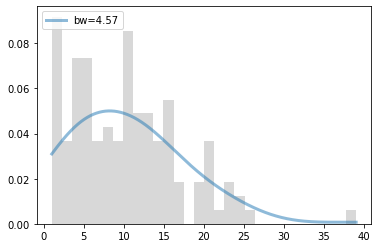

In [10]:
nvisits = mdat.groupby('SDAN').Participant_Type2.count().values.reshape(-1, 1)
nvisits_kde = gskde(nvisits)

<AxesSubplot:ylabel='Count'>

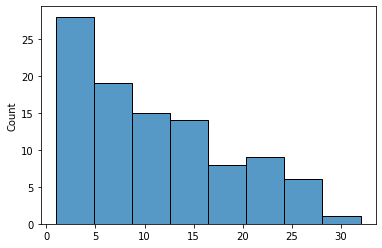

In [11]:
sim_nvisits = np.round(nvisits_kde.sample(100).squeeze())
sim_nvisits[sim_nvisits<1]=1
sns.histplot(sim_nvisits)

- Make a population of 10k
  - with a random effect and random subj_std each on the interval [0.5,2]
  - calculate effect sizes for MAE and RMSE in the population
- Draw 4 samples from it (n = 10, n = 72, n = 200, n = 1000)
- Run foldwise bootstrap for each sample

In [12]:
from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import rpy2.robjects.packages as rpackages

simr = rpackages.importr('simr')
lme4 = rpackages.importr('lme4')

rextend = robjects.r("""
    rextend <- function(ff, exdf, n, ss){
    mdl <- lmer(ff, data=exdf)
    sigma(mdl) <- ss
    mdl_ext_subj <- extend(mdl, along="SDAN", n=n)
    extended <- getData(mdl_ext_subj)
    responseName <- formula(mdl)[[2]]
    y <- doSim(mdl_ext_subj)
    return(list(extended,y))
    }
    """)
def sim_pop(formula, data, n, sigma):
    df = pd.read_csv(data)
    exdf = robjects.r(f"""exdf <- read.csv("{data}")
    exdf
    """)
    n_with_orig = n + df.SDAN.nunique()
    popdf, simy = rextend(formula, exdf, n_with_orig, sigma)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        popdf = pd.DataFrame(robjects.conversion.rpy2py(popdf))
    popdf = popdf.rename(columns={'error': 'null'})
    popdf['sim'] = simy
    
    return popdf

# make a null pop
# then modify the null pop to have different sigma

In [13]:
resdf = reses.loc[reses.model == 'MFQ+FH', ['SDAN','error']].reset_index(drop=True)
resdf.to_csv('resdf.csv', index=None)

In [14]:
resdf.SDAN.nunique()/2

64.5

In [15]:
pop_n = 10000
npops = 2000
samp_ns = [65, 129, 300, 1000]

In [16]:
def pool_sim_sd(x0, x1):
    assert x0.shape == x1.shape
    n = x0.shape[0]
    v0 = x0.var(0)
    v1 = x1.var(0)
    return np.sqrt((v0 + v1)/2)

In [21]:
real_std = real_mdl.ranef_var.loc['Residual', 'Std']

In [22]:
kfold = KFold(n_splits=8)

In [23]:
bootstrap_folds = list(itertools.product(range(8), repeat=8))
bootstrap_folds = set([tuple(sorted(x)) for x in bootstrap_folds])
boot_skeleton = []
for iix, inds in enumerate(bootstrap_folds):
    for bsfi, ix in enumerate(inds):
        row = {}
        row['bsi'] = iix
        row['bsfold'] = bsfi
        row['fold'] = ix
        boot_skeleton.append(row)
boot_skeleton = pd.DataFrame(boot_skeleton)

In [24]:
metrics = {'rmse':lambda x: x**2, 'mae': np.abs}

In [25]:
sim_dat = []
sim_number = -1
sim_info = []
residual_changes = rng.uniform(0.25, 3.5, npops)

for pi, residual_change in enumerate(residual_changes):
    print(pi)
    sim_sigma = real_std * residual_change
    popdf = sim_pop('error ~ 1 + (1| SDAN)', 'resdf.csv', pop_n, sim_sigma)
    pop_null = popdf.null.values
    pop_sim = popdf.sim.values
    for metric, func in metrics.items():
        for weighting in ['', '_unweighted']:
            si_row = {}
            si_row['pop_number'] = pi
            si_row['metric'] = metric + weighting
            si_row['residual_change'] = residual_change
            pfsim = func(pop_sim)
            pfnull = func(pop_null)
            if weighting == '_unweighted':
                tmp = popdf.copy()
                tmp['null'] = pfnull
                tmp['sim'] = pfsim
                pfnull = tmp.groupby('SDAN').null.mean().values
                pfsim = tmp.groupby('SDAN').sim.mean().values
            pop_md = (pfsim.mean() - pfnull.mean())
            pop_pd = pool_sim_sd(pfsim, pfnull)
            pop_d = pop_md/pop_pd
            si_row['pop_md'] = pop_md
            si_row['pop_pd'] = pop_pd
            si_row['pop_d'] = pop_d
            sim_info.append(si_row)
    for six, n in enumerate(samp_ns):
        sim_number += 1
        sids = rng.choice(popdf.SDAN, size=n, replace=False)
        samp = popdf.loc[popdf.SDAN.isin(sids), :]
        samp_null = samp.loc[:, 'null'].values
        samp_sim =  samp.loc[:, 'sim'].values
        folds = np.zeros(sids.shape)
        for kfi, (train_inds, test_inds) in enumerate(kfold.split(sids)):
            folds[test_inds] = kfi
        folddf = pd.DataFrame({'sid':sids, 'fold':folds})
        for metric, func in metrics.items():
            tmp_null = func(samp_null)
            tmp_sim = func(samp_sim)
            chunk = samp.copy()        
            chunk['pop_number'] = pi
            chunk['sim_number'] = sim_number
            chunk['n'] = n
            chunk['metric'] = metric
            chunk = chunk.rename(columns={'SDAN':'sid'})
            chunk['null'] = tmp_null
            chunk['sim'] = tmp_sim
            chunk = chunk.merge(folddf, how='left', on='sid')
            sim_dat.append(chunk)
sim_dat = pd.concat(sim_dat)
sim_info = pd.DataFrame(sim_info)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [26]:
sim_agg = sim_dat.groupby([ 'pop_number', 'sim_number', 'n','fold', 'metric']).mean().drop('sid', axis=1)
sim_agg.loc[(slice(None), slice(None), slice(None), slice(None), 'rmse'), :] = np.sqrt(sim_agg.xs('rmse', level="metric"))
sim_agg = sim_agg.reset_index()

# Deal with unweighted metrics
sim_agg_uw = sim_dat.groupby([ 'pop_number', 'sim_number', 'n', 'fold', 'sid', 'metric']).mean().groupby(['pop_number', 'sim_number', 'n', 'fold', 'metric']).mean()
sim_agg_uw.loc[(slice(None), slice(None), slice(None), slice(None), 'rmse'), :] = np.sqrt(sim_agg_uw.xs('rmse', level="metric"))
sim_agg_uw = sim_agg_uw.reset_index()
sim_agg_uw['metric'] = sim_agg_uw.metric + '_unweighted'

sim_agg = pd.concat([sim_agg, sim_agg_uw]).sort_values(['pop_number', 'sim_number', 'n','fold', 'metric']).reset_index(drop=True)

In [27]:
sim_res = sim_agg.groupby(['pop_number', 'sim_number', 'n', 'metric']).apply(foldwise_bootstrap)
sim_res = sim_res.reset_index()

In [28]:
sim_res['sig_pos'] = (np.sign(sim_res['0.05%']) == np.sign(sim_res['99.95%'])) & (sim_res['0.05%'] > 0)
sim_res['sig_neg'] = (np.sign(sim_res['0.05%']) == np.sign(sim_res['99.95%'])) & (sim_res['0.05%'] < 0)

In [29]:
sim_ri = sim_res.merge(sim_info, how='left', on=['pop_number', 'metric'])

In [30]:
sim_ri['type_s'] = (np.sign(sim_ri['0.05%']) == np.sign(sim_ri['99.95%'])) & (np.sign(sim_ri['0.05%']) != np.sign(sim_ri['pop_d']))
sim_ri['sig'] = sim_ri['sig_pos'] | sim_ri['sig_neg']
sim_ri['abs_d'] = np.abs(sim_ri.pop_d)

In [31]:
#sim_ri.to_csv('../data/mfq_powersim.csv', index=None)

In [32]:
sim_ri.groupby(['n', 'metric']).type_s.mean()

n     metric         
65    mae                0.0010
      mae_unweighted     0.0000
      rmse               0.0000
      rmse_unweighted    0.0000
129   mae                0.0000
      mae_unweighted     0.0000
      rmse               0.0000
      rmse_unweighted    0.0000
300   mae                0.0000
      mae_unweighted     0.0015
      rmse               0.0005
      rmse_unweighted    0.0000
1000  mae                0.0000
      mae_unweighted     0.0030
      rmse               0.0005
      rmse_unweighted    0.0015
Name: type_s, dtype: float64

In [33]:
sim_ri

,pop_number,sim_number,n,metric,count,mean,std,min,0.05%,2.5%,...,max,sig_pos,sig_neg,residual_change,pop_md,pop_pd,pop_d,type_s,sig,abs_d
0,0,0,65,mae,6435.0,-1.370829,0.186169,-2.234072,-2.124169,-1.798767,...,-0.925381,False,True,0.429509,-1.617566,2.215967,-0.729960,False,True,0.729960
1,0,0,65,mae_unweighted,6435.0,-1.445744,0.203999,-2.450921,-2.319141,-1.929210,...,-0.923372,False,True,0.429509,-1.770809,1.239220,-1.428970,False,True,1.428970
2,0,0,65,rmse,6435.0,-1.706510,0.252119,-2.885129,-2.731992,-2.282845,...,-0.949839,False,True,0.429509,-14.304092,22.040332,-0.648996,False,True,0.648996
3,0,0,65,rmse_unweighted,6435.0,-1.820452,0.266101,-3.077942,-2.922165,-2.429171,...,-0.933013,False,True,0.429509,-15.838199,12.160838,-1.302394,False,True,1.302394
4,0,1,129,mae,6435.0,-1.524600,0.165506,-1.972847,-1.940724,-1.809668,...,-0.769972,False,True,0.429509,-1.617566,2.215967,-0.729960,False,True,0.729960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,1999,7998,300,rmse_unweighted,6435.0,2.555220,0.139959,2.024837,2.085261,2.265072,...,3.024245,True,False,1.702238,31.491083,27.778932,1.133632,False,True,1.133632
31996,1999,7999,1000,mae,6435.0,2.225716,0.072247,2.066904,2.076411,2.114519,...,2.568471,True,False,1.702238,2.175362,3.671649,0.592475,False,True,0.592475
31997,1999,7999,1000,mae_unweighted,6435.0,2.076955,0.083968,1.918439,1.920704,1.947351,...,2.468090,True,False,1.702238,2.027419,1.774575,1.142481,False,True,1.142481
31998,1999,7999,1000,rmse,6435.0,2.831957,0.079781,2.659244,2.665740,2.706010,...,3.220500,True,False,1.702238,32.727335,57.770308,0.566508,False,True,0.566508


In [46]:
sim_ri.abs_d.max()/0.05

54.43039023399417

In [47]:
# get number of bins
nbins = min(len(np.histogram_bin_edges(sim_ri.abs_d, bins="fd")), 50)
nbins = 54
_, bins = pd.cut(sim_ri.abs_d, nbins, retbins=True)
bin_labels = np.vstack((bins[:-1], bins[1:])).mean(0)
sim_ri['d_bin'] = pd.cut(sim_ri.abs_d, bins, labels=bin_labels)

<AxesSubplot:xlabel='abs_d', ylabel='Count'>

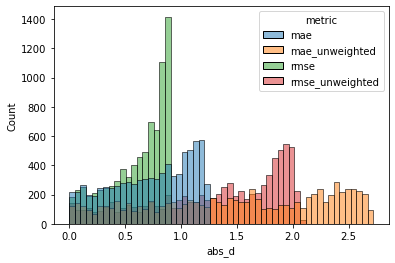

In [48]:
sns.histplot(data=sim_ri, x=sim_ri.abs_d, hue='metric', bins=bins)


In [111]:
sig_rates = pd.DataFrame(sim_ri.query('abs_d < 1').groupby(['d_bin', 'metric', 'n']).sig.mean()).reset_index()
sig_rates['metric'] = sig_rates.metric.replace({'mae': 'MAE', 'rmse': 'RMSE',
                                                'mae_unweighted': 'Unweighted MAE', 'rmse_unweighted': 'Unweighted RMSE'})
sig_rates['sig'] = sig_rates['sig'] * 100
sig_rates = sig_rates.rename(columns={'sig': '% Significant',
                                      'd_bin': "Absolute Cohen's d", 
                                      'metric': 'Metric'})

In [112]:
sig_rates['Weighting'] = 'Weighted'
sig_rates.loc[sig_rates.Metric.str.contains('Un'), 'Weighting'] = 'Unweighted'
sig_rates.loc[sig_rates.Metric.str.contains('MAE'), 'Metric'] = 'MAE'
sig_rates.loc[sig_rates.Metric.str.contains('RMSE'), 'Metric'] = 'RMSE'

In [80]:
sig_rates

,Population Cohen's D,Metric,n,% Significant,Weighting
0,0.024178,MAE,65,5.454545,Weighted
1,0.024178,MAE,129,3.636364,Weighted
2,0.024178,MAE,300,10.909091,Weighted
3,0.024178,MAE,1000,25.454545,Weighted
4,0.024178,MAE,65,0.000000,Unweighted
...,...,...,...,...,...
859,2.696323,RMSE,1000,NaN,Weighted
860,2.696323,RMSE,65,NaN,Unweighted
861,2.696323,RMSE,129,NaN,Unweighted
862,2.696323,RMSE,300,NaN,Unweighted


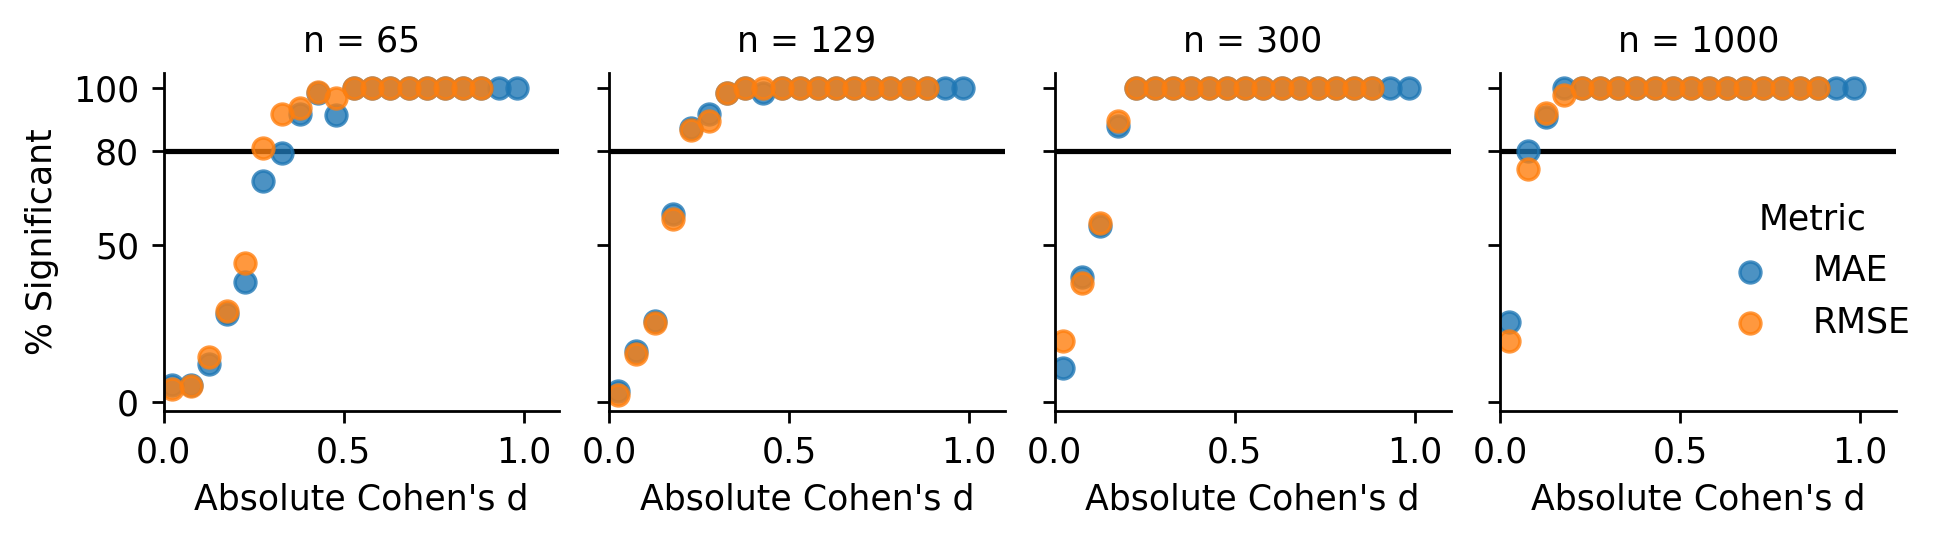

In [113]:
g = sns.lmplot(x="Absolute Cohen's d", y='% Significant',hue='Metric', col='n', data=sig_rates.query("Weighting == 'Weighted'"), fit_reg=False, lowess=True)
#g.ax.set_title('Power simulation for residual differences\non Weeks of Depression data.')
for ax in g.axes.flatten():
    ax.set_yticks((0,50,80,100))
    ax.hlines(80, 0, 1.1, 'black', zorder=0)
    ax.set_xlim((0,1.1))

g.fig.set_facecolor('white')
g.fig.set_dpi(250)
g.fig.set_size_inches(7.5,2)
g.fig.tight_layout()

In [ ]:
sim_ri.query('pop_d > 0.175 & pop_d < 0.225').groupby('n').mean()

In [97]:
sim_ri['abs_popmd'] = np.abs(sim_ri.pop_md)

In [98]:
sim_ri.query('abs_d > 0.19 & abs_d < 0.22 & metric == "mae"').groupby('n').mean()

,pop_number,sim_number,count,mean,std,min,0.05%,2.5%,50%,97.5%,...,sig_pos,sig_neg,residual_change,pop_md,pop_pd,pop_d,type_s,sig,abs_d,abs_popmd
n,,,,,,,,,,,,,,,,,,,,,
65,1148.3125,4593.25,6435.0,0.218001,0.219476,-0.547396,-0.473555,-0.218453,0.220308,0.641702,...,0.28125,0.09375,1.056058,0.150093,2.812624,0.037908,0.0,0.3750,0.206316,0.580148
129,1148.3125,4594.25,6435.0,0.220162,0.147592,-0.265534,-0.222598,-0.065966,0.219490,0.511386,...,0.50000,0.31250,1.056058,0.150093,2.812624,0.037908,0.0,0.8125,0.206316,0.580148
300,1148.3125,4595.25,6435.0,0.245288,0.103108,-0.108942,-0.077499,0.039986,0.246161,0.443665,...,0.59375,0.40625,1.056058,0.150093,2.812624,0.037908,0.0,1.0000,0.206316,0.580148
1000,1148.3125,4596.25,6435.0,0.232974,0.051455,0.044284,0.063548,0.127052,0.234960,0.327534,...,0.59375,0.40625,1.056058,0.150093,2.812624,0.037908,0.0,1.0000,0.206316,0.580148


81.3% chance to detect a significant effect with an absolute population Cohen's d between 0.19 and 0.22 and a sample of 129 participants when using MAE. This corresponds to an absolute mean MAE difference of 0.58 assuming a pooled standard deviation of 2.81, which we based on our simulations. Similarly, we found a 79.3% chance to detect an absolute population Cohen's d between 0.19 and 0.22 and a sample of 129 participants when using RMSE. This corresponds to an absolute mean squared error difference of 6.47 squared MFQ points assuming a pooled standard deviation of 31.35 squared MFQ points or an average RMSE difference of 0.722.



In [104]:
sim_ri.query('abs_d > 0.19 & abs_d < 0.22 & metric == "rmse" & n == 129').groupby('n').mean()

,pop_number,sim_number,count,mean,std,min,0.05%,2.5%,50%,97.5%,...,sig_pos,sig_neg,residual_change,pop_md,pop_pd,pop_d,type_s,sig,abs_d,abs_popmd
n,,,,,,,,,,,,,,,,,,,,,
129,1003,4013,6435.0,0.245685,0.172669,-0.316308,-0.267957,-0.087813,0.244192,0.587679,...,0.482759,0.310345,1.044853,1.984723,31.350567,0.034673,0.0,0.793103,0.206587,6.473243


In [105]:
res_changes_for_rmse_dif = sim_ri.query('abs_d > 0.19 & abs_d < 0.22 & metric == "rmse" & n == 129').groupby('pop_number').residual_change.first()

In [106]:
rmse_dif = []
for pi, residual_change in enumerate(res_changes_for_rmse_dif):
    print(pi)
    sim_sigma = real_std * residual_change
    popdf = sim_pop('error ~ 1 + (1| SDAN)', 'resdf.csv', pop_n, sim_sigma)
    pop_null = popdf.null.values
    pop_sim = popdf.sim.values
    metric = 'rmse'
    func = metrics[metric]
    for weighting in ['']:
        si_row = {}
        si_row['pop_number'] = pi
        si_row['metric'] = metric + weighting
        si_row['residual_change'] = residual_change
        pfsim = func(pop_sim)
        pfnull = func(pop_null)
        if weighting == '_unweighted':
            tmp = popdf.copy()
            tmp['null'] = pfnull
            tmp['sim'] = pfsim
            pfnull = tmp.groupby('SDAN').null.mean().values
            pfsim = tmp.groupby('SDAN').sim.mean().values
        pop_rmsedif = np.sqrt(pfsim.mean()) - np.sqrt(pfnull.mean())
        si_row['pop_nullmse'] = pfnull.mean()
        si_row['pop_nullrmse'] = np.sqrt(pfnull.mean())
        si_row['pop_simmse'] = pfsim.mean()
        si_row['pop_simrmse'] = np.sqrt(pfsim.mean())        
        
        si_row['pop_rmsedif'] = pop_rmsedif
        rmse_dif.append(si_row)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [77]:
rmse_dif = pd.DataFrame(rmse_dif)
rmse_dif.mean()

pop_number         13.500000
residual_change     1.190950
pop_nullmse        20.854030
pop_nullrmse        4.566621
pop_simmse         27.977563
pop_simrmse         5.289083
pop_rmsedif         0.722462
dtype: float64

In [119]:
mdat_single = mdat.groupby('SDAN').sample()
mfq_fh_single_model = 's_mfq_tot ~ dep_immed*TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic'

In [120]:
mdl = smf.ols(mfq_fh_single_model, mdat_single)
fitted = mdl.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              s_mfq_tot   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     16.03
Date:                Wed, 22 Sep 2021   Prob (F-statistic):           7.16e-18
Time:                        14:16:03   Log-Likelihood:                -373.08
No. Observations:                 129   AIC:                             768.2
Df Residuals:                     118   BIC:                             799.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.5035      4.165      1.321      0.189      -2.744      13.751
dep_immed                -0.9554      1.519     -0.629      0.531      -3.964       2.053
TimeBetween              -4.1239      4.723     -0.873      0.384     -13.476       5.228
dep_immed:TimeBetween     1.1597      5.000      0.232      0.817      -8.742      11.061
MFQtminus1                0.7511      0.064     11.674      0.000       0.624       0.879
InpatientDuring          -1.8868      1.549     -1.218      0.226      -4.955       1.181
Age_at_visit             -0.1285      0.238     -0.539      0.591      -0.601       0.344
SEX                      -0.1458      0.981     -0.149      0.882      -2.089       1.797
antidepressants          -0.4120      0.960     -0.429      0.669      -2.313       1.489
OtherMeds                 2.0154      1.095      1.841      0.068      -0.152       4.183
postpandemic              0.6513      0.993      0.656      0.513      -1.314       2.617
==============================================================================
Omnibus:                        9.781   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.894
Skew:                           0.663   Prob(JB):                      0.00711
Kurtosis:                       3.286   Cond. No.                         360.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
np.var(mdat_single.s_mfq_tot)

44.888138527607715

In [122]:
np.var(mdat_single.s_mfq_tot) * 0.576

25.855567791902043

In [123]:
np.var(mdat_single.s_mfq_tot) * 0.576 * 0.0322

0.8325492828992458

In [124]:
np.sqrt(np.var(mdat_single.s_mfq_tot) * 0.576 * 0.0322)

0.912441386007477